In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
datagen_train = keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255,
    validation_split=.2,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

batch_size=64

train_generator = datagen_train.flow_from_directory(
    '/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Training',
    seed=42,
    target_size=(224,224),
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True,
)

val_generator = datagen_train.flow_from_directory(
    '/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Validation',
    seed=42,
    target_size=(224,224),
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [12]:
from matplotlib.image import imread

takeapeak = imread('/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Training/female/131422.jpg.jpg'
)
takeapeak.shape

(114, 92, 3)

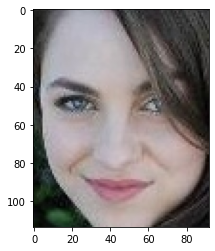

In [17]:
plt.imshow(takeapeak)

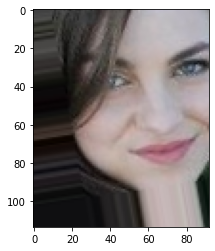

In [18]:
plt.imshow(datagen_train.random_transform(takeapeak))

In [19]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, concatenate

In [20]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [40]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(2, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(2, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(2, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [41]:
model = GoogLeNet()

In [42]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_177 (Conv2D)            (None, 109, 109, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_177[0][0]']             
 )                                                                                        

                                                                                                  
 conv2d_202 (Conv2D)            (None, 12, 12, 24)   12312       ['concatenate_29[0][0]']         
                                                                                                  
 max_pooling2d_45 (MaxPooling2D  (None, 12, 12, 512)  0          ['concatenate_29[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_199 (Conv2D)            (None, 12, 12, 160)  82080       ['concatenate_29[0][0]']         
                                                                                                  
 conv2d_201 (Conv2D)            (None, 12, 12, 224)  226016      ['conv2d_200[0][0]']             
                                                                                                  
 conv2d_20

                                                                                                  
 conv2d_227 (Conv2D)            (None, 5, 5, 32)     26656       ['max_pooling2d_49[0][0]']       
                                                                                                  
 max_pooling2d_50 (MaxPooling2D  (None, 5, 5, 832)   0           ['max_pooling2d_49[0][0]']       
 )                                                                                                
                                                                                                  
 conv2d_224 (Conv2D)            (None, 5, 5, 256)    213248      ['max_pooling2d_49[0][0]']       
                                                                                                  
 conv2d_226 (Conv2D)            (None, 5, 5, 320)    461120      ['conv2d_225[0][0]']             
                                                                                                  
 conv2d_22

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [44]:
history = model.fit(train_generator, validation_data=val_generator, validation_steps = val_generator.samples // batch_size,
                   epochs=20,
                   steps_per_epoch = train_generator.samples // batch_size)

Epoch 1/20
734/734 [==============================] - 877s 1s/step - loss: 2.0352 - dense_19_loss: 0.6743 - dense_16_loss: 0.6847 - dense_18_loss: 0.6762 - dense_19_accuracy: 0.5686 - dense_16_accuracy: 0.5613 - dense_18_accuracy: 0.5705 - val_loss: 1.9363 - val_dense_19_loss: 0.6328 - val_dense_16_loss: 0.6683 - val_dense_18_loss: 0.6353 - val_dense_19_accuracy: 0.6446 - val_dense_16_accuracy: 0.6196 - val_dense_18_accuracy: 0.6465
Epoch 2/20
734/734 [==============================] - 935s 1s/step - loss: 1.9114 - dense_19_loss: 0.6266 - dense_16_loss: 0.6556 - dense_18_loss: 0.6291 - dense_19_accuracy: 0.6478 - dense_16_accuracy: 0.6240 - dense_18_accuracy: 0.6477 - val_loss: 1.8886 - val_dense_19_loss: 0.6270 - val_dense_16_loss: 0.6399 - val_dense_18_loss: 0.6216 - val_dense_19_accuracy: 0.6511 - val_dense_16_accuracy: 0.6465 - val_dense_18_accuracy: 0.6524
Epoch 3/20
734/734 [==============================] - 1177s 2s/step - loss: 1.7761 - dense_19_loss: 0.5702 - dense_16_loss: 0.

Epoch 20/20
734/734 [==============================] - 1101s 1s/step - loss: 0.7098 - dense_19_loss: 0.2065 - dense_16_loss: 0.2905 - dense_18_loss: 0.2127 - dense_19_accuracy: 0.9191 - dense_16_accuracy: 0.8837 - dense_18_accuracy: 0.9162 - val_loss: 0.6590 - val_dense_19_loss: 0.1903 - val_dense_16_loss: 0.2722 - val_dense_18_loss: 0.1966 - val_dense_19_accuracy: 0.9266 - val_dense_16_accuracy: 0.8937 - val_dense_18_accuracy: 0.9221
